# Dataset

Frame is a message schema written in Proto3 syntax that is used to represent a frame containing data from multiple cameras and lidars. It is written in a format that can be easily parsed and manipulated using Python.

### Frame:

- **id** *(string)*: A unique identifier for the frame
- **cameras** *(list of Camera Object)*: contains data from multiple cameras
- **lidars** *(list of Lidar Object)*: contains data from multiple lidars

### Camera:

- **data** *(bytes fiel)*: the raw image data from the camera
- **width** *(int32 field)*: the width of the image in pixels
- **height** *(int32 field)*: the height of the image in pixels
- **depth** *(int32 field)*: the number of channels in the image (e.g. 3 for RGB)
- **T** *(list of float field)*: a list of transformation values that describe the position and orientation of the camera in space
- **pos** *(Position message field)*: a Position enum value that describes the position of the camera relative to the vehicle
- **detections** *(list of CameraDetection field)*: contains a list of CameraDetection messages, each of which represents an object detection within the camera's view

### CameraDetection:

- **id** *(string field)*: a unique identifier for the detected object
- **type** *(ObjectType field)*: an ObjectType enum value that indicates the type of object detected
- **bbox** *(list of float field)*: a list of four float values that represent the bounding box coordinates of the detected object in the image (x0, y0, width, height)

### Lidar:

- **data** *(list of float field)*: a list of raw lidar data points
- **width** *(int32 field)*: the number of horizontal points in the lidar scan
- **height** *(int32 field)*: the number of vertical points in the lidar scan
- **channels** *(int32 field)*: the number of channels in each lidar point (e.g. 3 for x, y, z coordinates)
- **T** *(list of float field)*: a list of transformation values that describe the position and orientation of the lidar in space
- **pos** *(Position message field)*: a Position enum value that describes the position of the lidar relative to the vehicle
- **detections** *(list of LidarDetection field)*: contains a list of LidarDetection messages, each of which represents an object detection within the lidar's range

### LidarDetection:

- **id** *(string field)*: a unique identifier for the detected object
- **type** *(ObjectType enum field)*: an ObjectType enum value that indicates the type of object detected
- **pos** *(repeated float field)*: a list of three float values that represent the x, y, and z coordinates of the center of the detected object in 3D space
- **rot** *(repeated float field)*: a list of three float values that represent the roll, pitch, and yaw angles of the detected object in 3D space
- **scale** *(repeated float field)*: a list of three float values that represent the x, y, and z scale of the detected object in 3D space


# Imports

In [1]:
import os

from PIL import Image
import torch

import tools.dataset_tools as dataset_tools
from tools.frame_pb2 import Frame
import tools.plot_tools as plot_tools

In [2]:
torch.cuda.is_available()

False

In [3]:
frame = dataset_tools.read_frame("../Dataset/data_2/frame_0.pb")

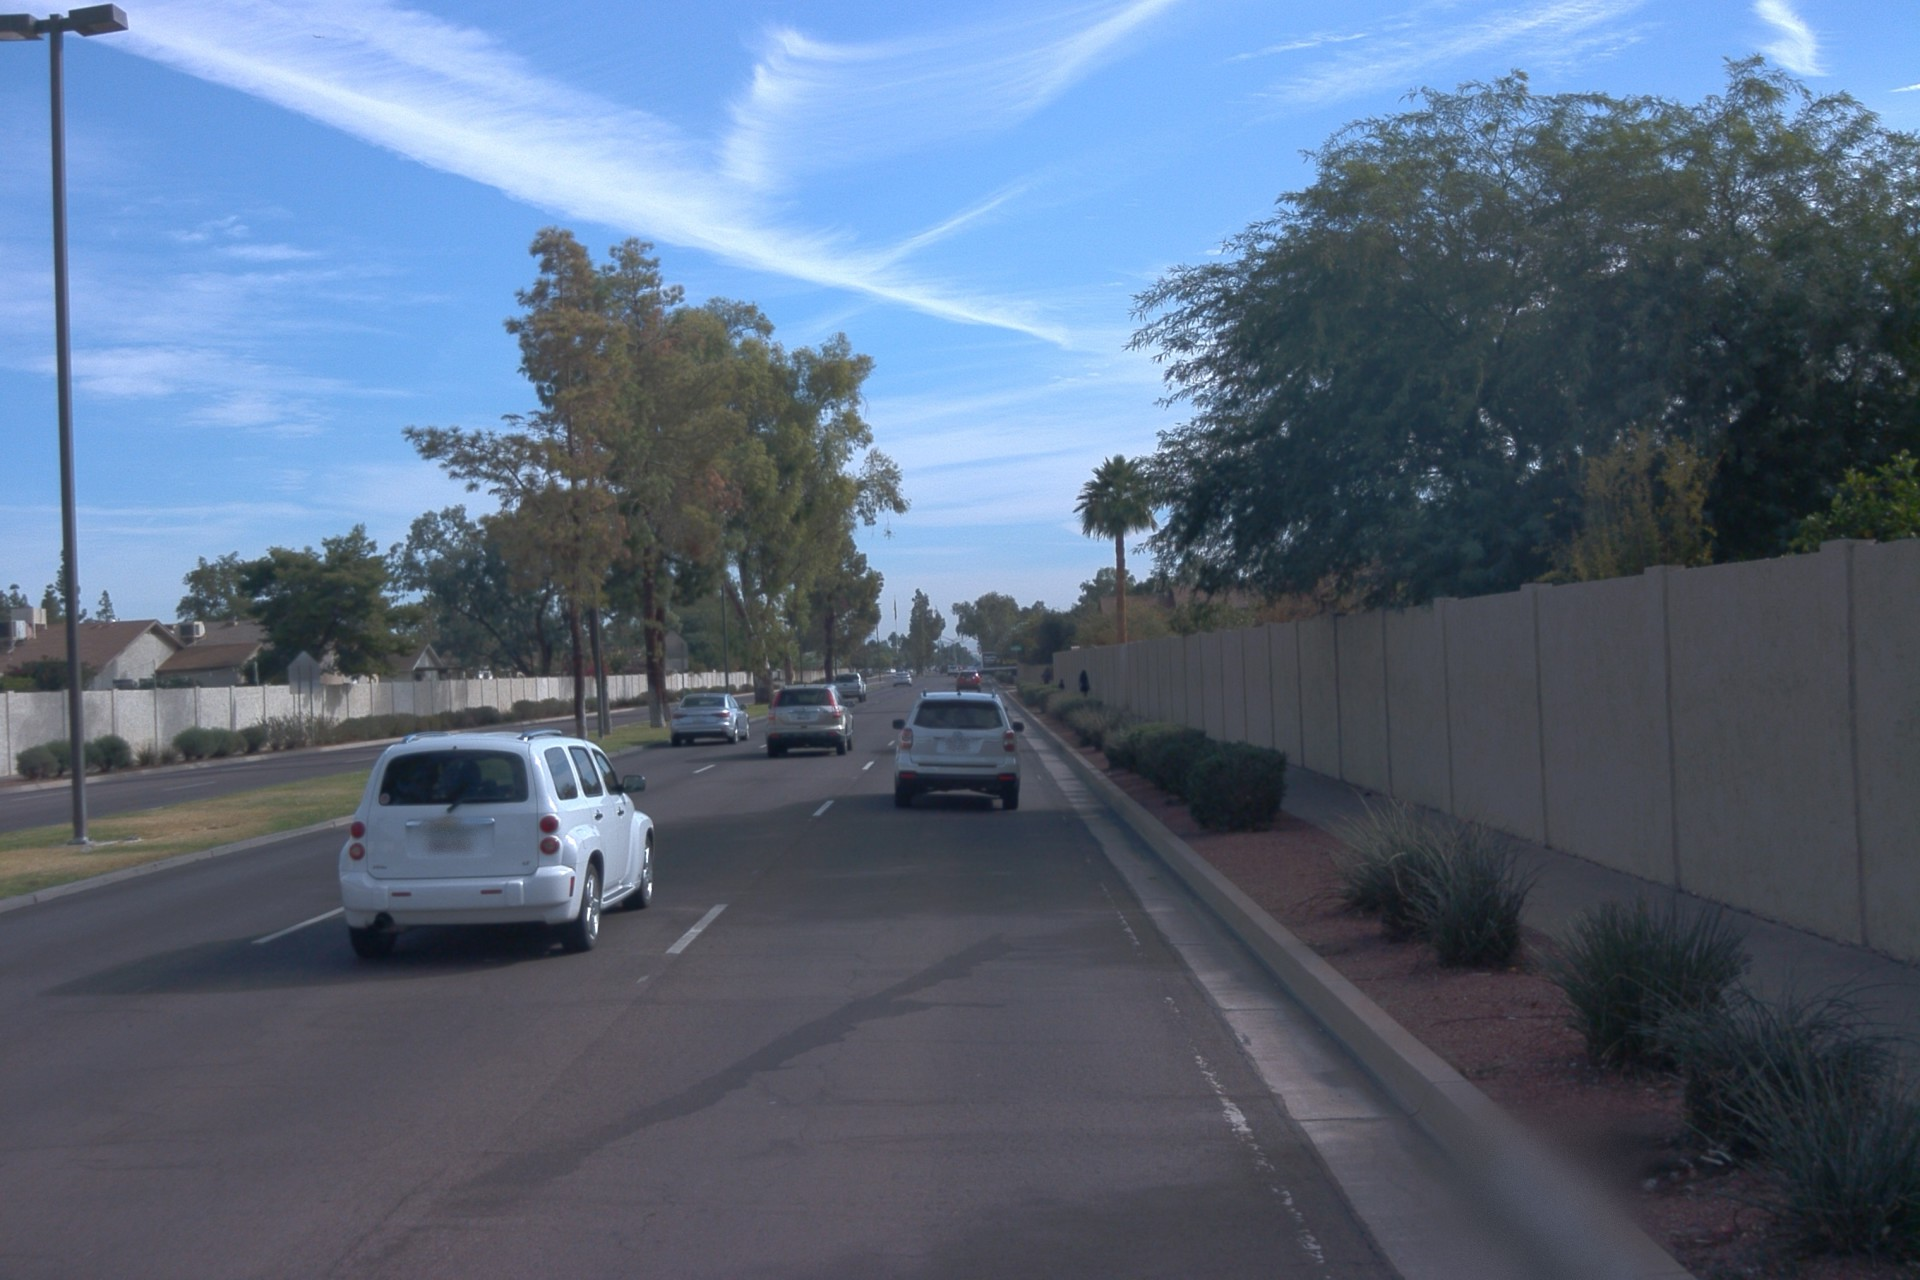

In [4]:
camera = frame.cameras[0]

img = dataset_tools.decode_img(camera)

image = Image.fromarray(img)
image.show()

In [6]:
from ipywidgets import interact, fixed
import open3d as o3d
print(o3d.__version__)
import numpy as np
from IPython.display import HTML

lidar = frame.lidars[0]
pcl = dataset_tools.decode_lidar(lidar)
print(pcl.shape)

pointcloud = o3d.geometry.PointCloud()
pointcloud.points = o3d.utility.Vector3dVector(pcl[:,:3])
# # o3d.visualization.draw_geometries([pointcloud], background=(0,0,0), point_size=0.3)
vis = o3d.visualization.Visualizer()
vis.create_window()
vis.add_geometry(pointcloud)

opt = vis.get_render_option()
opt.background_color = (0, 0, 0)
opt.point_size = 2

vis.run()
vis.destroy_window()
del opt  # Delete to avoid having  [Open3D ERROR] GLFW Error: The GLFW library is not initialized
del vis  # Delete to avoid having  [Open3D ERROR] GLFW Error: The GLFW library is not initialized

0.18.0
(196608, 4)


In [12]:
pcl.shape

(196608, 4)

In [1]:
class Track:
    
    def __init__(self, detection):
        self.x = np.asarray(detection.pos)
        self.l = detection.scale[0]
        self.w = detection.scale[1]
        self.h = detection.scale[2]
        self.yaw = detection.rot[2]
        self.state = "initialized"
        self.id = detection.id

tracks = [Track(detection) for detection in lidar.detections if detection.pos[0]>0 and detection.pos[0]<50]

plot_tools.plot_tracks(img,tracks,[], lidar.detections, camera)

NameError: name 'lidar' is not defined

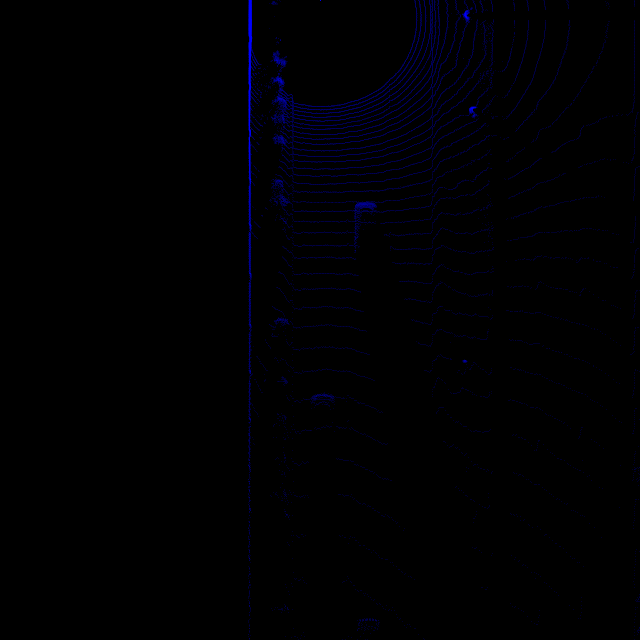

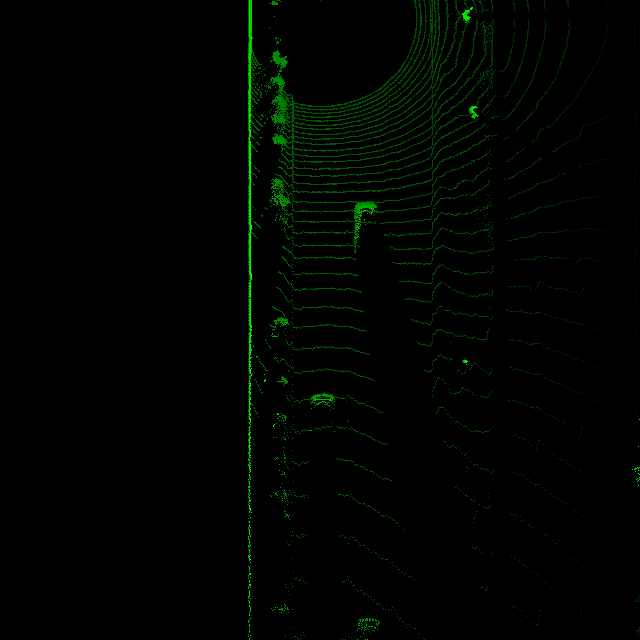

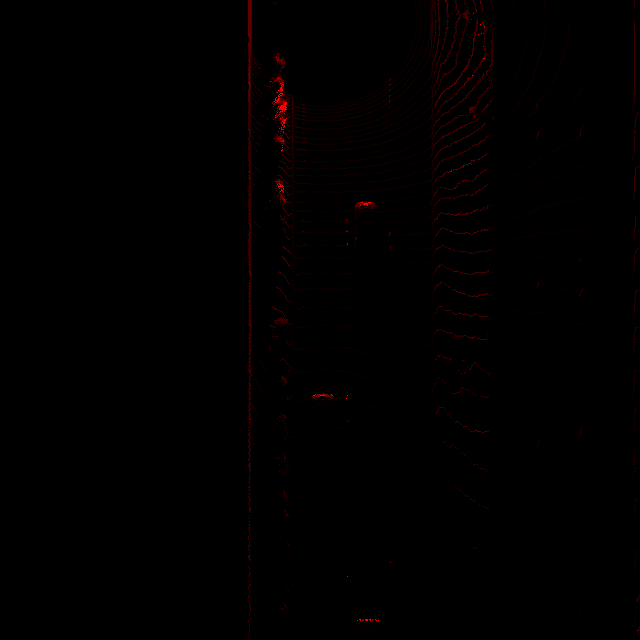

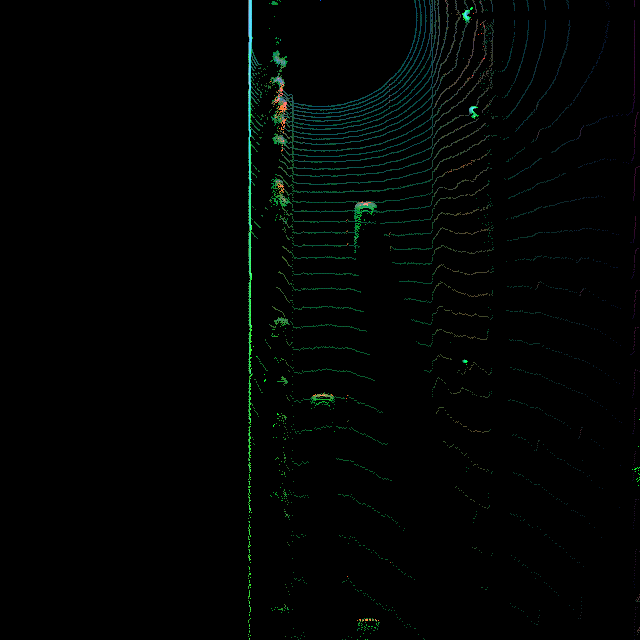

In [7]:
from easydict import EasyDict as edict
from typing import Tuple

def pcl_to_bev(pcl:np.ndarray, configs: edict) -> np.ndarray:
    """Computes the bev map of a given pointcloud. 
    
    For generality, this method can return the bev map of the available 
    channels listed in '''BEVConfig.VALID_CHANNELS'''. 

    Parameters
    ----------
        pcl (np.ndarray): pointcloud as a numpy array of shape [n_points, m_channles] 
        configs (Dict): configuration parameters of the resulting bev_map

    Returns
    -------
        bev_map (np.ndarray): bev_map as numpy array of shape [len(config.channels), configs.bev_height, configs.bev_width ]
    """
    
    # remove lidar points outside detection area and with too low reflectivity
    mask = np.where((pcl[:, 0] >= configs.lims.x[0]) & (pcl[:, 0] <= configs.lims.x[1]) &
                    (pcl[:, 1] >= configs.lims.y[0]) & (pcl[:, 1] <= configs.lims.y[1]) &
                    (pcl[:, 2] >= configs.lims.z[0]) & (pcl[:, 2] <= configs.lims.z[1]))
    pcl = pcl[mask]

    # shift level of ground plane to avoid flipping from 0 to 255 for neighboring pixels
    pcl[:, 2] = pcl[:, 2] - configs.lims.z[0]  

    # Convert sensor coordinates to bev-map coordinates (center is bottom-middle)
    # compute bev-map discretization by dividing x-range by the bev-image height
    bev_x_discret = (configs.lims.x[1] - configs.lims.x[0]) / configs.bev_height
    bev_y_discret = (configs.lims.y[1] - configs.lims.y[0]) / configs.bev_width
    ## transform all metrix x-coordinates into bev-image coordinates    
    pcl_cpy = np.copy(pcl)
    pcl_cpy[:, 0] = np.int_(np.floor(pcl_cpy[:, 0] / bev_x_discret))
    # transform all y-coordinates making sure that no negative bev-coordinates occur
    pcl_cpy[:, 1] = np.int_(np.floor(pcl_cpy[:, 1] / bev_y_discret) + (configs.bev_width + 1) / 2) 
    # Create BEV map
    bev_map = np.zeros((3, configs.bev_height, configs.bev_width))
    # Compute height and density channel
    pcl_height_sorted, counts = sort_and_map(pcl_cpy, 2, return_counts=True)
    xs = np.int_(pcl_height_sorted[:, 0])
    ys = np.int_(pcl_height_sorted[:, 1])
    # Fill height map
    normalized_height = pcl_height_sorted[:, 2]/float(np.abs(configs.lims.z[1] - configs.lims.z[0]))
    height_map = np.zeros((configs.bev_height + 1, configs.bev_width + 1))
    height_map[xs,ys] = normalized_height
    
    # Fill density map
    normalized_density = np.minimum(1.0, np.log(counts + 1) / np.log(64))
    density_map = np.zeros((configs.bev_height + 1, configs.bev_width + 1))
    density_map[xs,ys] = normalized_density

    # Compute intesity channel
    pcl_cpy[pcl_cpy[:,3]>configs.lims.intensity[1],3] = configs.lims.intensity[1]
    pcl_cpy[pcl_cpy[:,3]<configs.lims.intensity[0],3] = configs.lims.intensity[0]
    
    pcl_int_sorted, _ = sort_and_map(pcl_cpy, 3, return_counts=False)
    xs = np.int_(pcl_int_sorted[:, 0])
    ys = np.int_(pcl_int_sorted[:, 1])
    normalized_int = pcl_int_sorted[:, 3]/(np.amax(pcl_int_sorted[:, 3])-np.amin(pcl_int_sorted[:, 3]))
    intensity_map = np.zeros((configs.bev_height + 1, configs.bev_width + 1))
    intensity_map[xs,ys] = normalized_int
    
    # Fill BEV 
    bev_map[2,:,:] = density_map[:configs.bev_height, :configs.bev_width]
    bev_map[1,:,:] = height_map[:configs.bev_height, :configs.bev_width]
    bev_map[0,:,:] = intensity_map[:configs.bev_height, :configs.bev_width]
 
    return bev_map

def sort_and_map(pcl: np.ndarray, channel_index: int, return_counts:bool=False) ->Tuple[np.ndarray,np.ndarray]:
    """Function to re-arrange elements in poincloud by sorting first by x, then y, then -channel.
    This function allows users to map a pointcloud channel to a top view image (in z axis) of that channel.

    Parameters
    ----------
        pcl (np.ndarray): Input pointcloud of of shape [n_points, m_channles]
        channel_index (int): Index of channel to take into account as third factor, 
                             when sorting the pointcloud.
        return_counts (bool): True to return the counts on points per cell. Used for density channel
    Returns
     ----------
       channel_map (np.ndarray): [description]
       counts (np.ndarray): [description]
       
    """

    idx= np.lexsort((-pcl[:, channel_index], pcl[:, 1], pcl[:, 0]))
    pcl_sorted = pcl[idx]
    counts = None
    # extract all points with identical x and y such that only the maximum value of the channel is kept
    if return_counts:
        _, indices, counts = np.unique(pcl_sorted[:, 0:2], axis=0, return_index=True, return_counts=return_counts)
    else:
        _, indices = np.unique(pcl_sorted[:, 0:2], axis=0, return_index=True)
    return (pcl_sorted[indices], counts)

def show_bev_map(bev_map: np.ndarray) -> None:
    """Function to show bev_map as an RGB image

    By default, the image will only show the 3 first channels of `bev_map`. 

    Parameters
    ----------
        bev_map (np.ndarray): bev_map as numpy array of shape `[len(config.channels), configs.bev_height, configs.bev_width ]` 
    """
    bev_image: np.ndarray =  (np.swapaxes(np.swapaxes(bev_map,0,1),1,2)*255).astype(np.uint8)
    mask: np.ndarray = np.zeros_like(bev_image[:,:,0])


    height_image = Image.fromarray(np.dstack((bev_image[:, :, 0],mask,mask)))
    den_image = Image.fromarray(np.dstack((mask,bev_image[:, :, 1],mask)))
    int_image = Image.fromarray(np.dstack((mask,mask,bev_image[:, :, 2])))

    int_image.show()
    den_image.show()
    height_image.show()
    Image.fromarray(bev_image).show()


configs = edict()
configs.lims = edict()
configs.lims.x = [0, 50]
configs.lims.y = [-25, 25]
configs.lims.z = [-1.5, 3]
configs.lims.intensity = [0, 1.0]
configs.bev_height = 640
configs.bev_width = 640

bev_map = pcl_to_bev(pcl, configs)
show_bev_map(bev_map)
